# 목표

- 기본적으로 주가를 예측하는 것을 목표로 한다.
- 주가를 예측하기 위해, 주가 데이터만 사용하는 것이 아니라 기업의 재무상태 또한 고려하려 한다.
- 여기서 문제점은 주가의 종가는 매일 업데이트 되지만 재무상태는 1년에 한 번 공시된다는 것이다. (물론 분기별 재무보고서가 있지만 수정되는 경우도 많고, 정확하지 않은 경우가 많아 사업계획서를 기준으로 한다.

### Imports

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fqtoolkit import dgToDf as dtd
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

In [3]:
from sklearn.tree import DecisionTreeRegressor

### Data 불러오기

- 데이터는 기본적으로 데이터 가이드에서 재공되는 주가정보와 재무 정보를 사용한다.
- 데이터 가이드에서 제공하는 회사 중 고려대상인 회사만을 선정하여 엑셀 파일로 미리 저장하였다. (data2.xlsx)

- 재무 정보는 재무재표를 기준으로 하고 재무재표에서는 대부분의 회사의 공통사항인 자산, 부채, 매출, 이익을 feature로 사용한다.
- 문제는 앞서 말한 주가 정보와 재무재표의 기간이 맞지 않는다는 것인데, 주가 데이터는 당월 종가를 기준으로 하고, 재무제표는 당년 6월에 발표된다고 가정하였다. 
- 2020년 1월에 투자를 한다고 가정하면, 2019년 6월에 발표된 재무제표를 기준으로 판단할 수 밖에 없기 때문에 price를 shift 해줘 주가 데이터와 재무 정보의 시작점을 같게 한다.

In [26]:
assets, liability, sale, income, price = [item[1] for item in dtd("data2.xlsx", "Sheet1", 5).items()]

In [27]:
assets0 = assets.pct_change()
liability0 = liability.pct_change()

In [28]:
price.shift(12)

,삼성전자,LG에너지솔루션,SK하이닉스,삼성바이오로직스,NAVER,삼성SDI,현대차,카카오,LG화학,기아,...,네이처셀,주성엔지니어링,SFA반도체,덕산네오룩스,메가스터디교육,NICE평가정보,피엔티,케어젠,와이지엔터테인먼트,에이비엘바이오
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
2000-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-02-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-31,80103,NaN,120733,783719,342542,732895,223825,88475,899806,79635,...,8900,9409,6900,33550,40568,20921,24415,67671,45148,24200
2022-02-28,80591,NaN,139459,741222,374499,672985,231644,97904,815419,76643,...,8010,10073,8690,42300,52040,21559,25711,64481,45496,20300
2022-03-31,79866,NaN,130589,739246,376496,659006,213073,99911,789906,80022,...,9970,11116,7550,45250,57703,24899,23219,63127,44302,21850


In [7]:
price = price.dropna(axis=1)
returns = price.shift(12+6).pct_change()

returns

,삼성전자,SK하이닉스,삼성SDI,현대차,카카오,기아,POSCO홀딩스,현대모비스,한국전력,SK텔레콤,...,기업은행,롯데케미칼,한국조선해양,한온시스템,HLB,CJ ENM,동진쎄미켐,동화기업,네이처셀,주성엔지니어링
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
2000-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-02-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-31,0.096598,-0.027025,0.093534,0.294771,0.284103,0.260543,0.112072,0.070313,-0.020492,0.045026,...,0.003782,0.008978,0.020595,0.099343,-0.097196,0.043517,0.122576,0.483533,0.048673,0.248111
2022-02-28,-0.067365,-0.092993,0.138365,0.395263,0.184868,0.050754,-0.046515,0.090025,0.073279,0.124718,...,-0.002512,0.124630,-0.033632,0.295209,0.038276,0.031274,0.050619,-0.092836,0.123418,-0.064293
2022-03-31,0.084328,0.118508,-0.041989,0.011329,-0.104420,0.104813,0.070547,0.026787,-0.004848,-0.040314,...,-0.009931,0.036941,-0.040603,-0.037232,0.194703,0.198822,-0.106929,-0.083426,-0.075117,0.064243


### Rolling
- Rolling 기간은 122달로 설정하였다.

In [8]:
rolling_period = 122
results = {}

for col in returns.columns:
    reSeries = {}
    for n in range(1, returns.shape[0]-rolling_period):
        
        temp = pd.DataFrame({"asset":assets0[col].iloc[n:n+rolling_period-1],
                            "liability":liability0[col].iloc[n:n+rolling_period-1],
                            "sale":sale[col].iloc[n:n+rolling_period-1],
                            "income":income[col].iloc[n:n+rolling_period-1],
                             "re0": returns[col].iloc[n-1:n+rolling_period-2],
                            "re": returns[col].iloc[n:n+rolling_period-1]})
        temp = temp.dropna()
        future = returns[col].iloc[n+120]
        
        if temp.shape[0] < 50:
            continue
            
        model = DecisionTreeRegressor(max_depth=6)#
        model.fit(temp.drop("re", axis=1).iloc[:-1,:], temp["re"].iloc[:-1])
        
        r = model.predict(temp.drop("re", axis=1).iloc[[-1], :])
        
        reSeries[temp.index[-1]] = temp["re"].iloc[-1]-r[0]
        
    if len(reSeries) > 0:
        results[col] = pd.Series(reSeries)

In [9]:
from sklearn.metrics import accuracy_score

In [29]:
r2 = []
acc = []

for n in range(12, 48):
    results = pd.DataFrame(results)
    signal = (results).mean(axis=1)

    signal = (signal-signal.shift(1).rolling(n).mean())/signal.shift(1).rolling(n).std() #변경 말것!
    temp = pd.DataFrame({"returns":returns.shift(-1).mean(axis=1), "result":signal}).dropna()

    test = temp.iloc[int(temp.shape[0]/4):2*int(temp.shape[0]/4), :]
    test0 = temp.iloc[2*int(temp.shape[0]/4):, :]
    
    training = temp.iloc[:int(temp.shape[0]/4), :]

    mu = training.result.mean()
    sd = training.result.std()

    test.result = (test.result-mu)/sd
    test0.result = (test0.result-mu)/sd
    training.result = (training.result - mu) /sd

    test["returns+"] = np.where(test["returns"] > 0, test["returns"], 0)
    test0["returns+"] = np.where(test0["returns"] > 0, test0["returns"], 0)

    test["port"] = test["returns"] * np.where(-test.result>2, 1, 0)
    test0["port"] = test0["returns"] *np.where(-test0.result>2, 1, 0)
    
    acc.append(accuracy_score(np.where(test.returns>0, 1, 0), np.where(-test.result>0, 1, 0)))

    from sklearn.metrics import accuracy_score

    print(f"{np.corrcoef(test.returns, -test.result)[1,0 ] ** 2 * 100:.4f}%")
    r2.append(np.corrcoef(test.returns, -test.result)[1,0 ] ** 2)

5.2551%
4.1939%
4.5590%
4.0466%
4.1345%
3.9364%
4.0842%
3.8153%
4.3680%
4.2771%
4.2926%
4.1198%
3.2673%
3.9586%
3.3871%
2.9074%
2.7154%
2.5338%
2.5542%
2.6349%
2.4692%
2.6193%
2.4704%
2.3006%
1.8799%
2.0193%
1.5068%
1.5204%
1.5876%
1.6272%
1.6214%
1.1958%
0.0534%
0.0430%
0.0549%
1.8270%


In [11]:
pd.Series(r2, index=range(12, 48)).argmax()+12

12

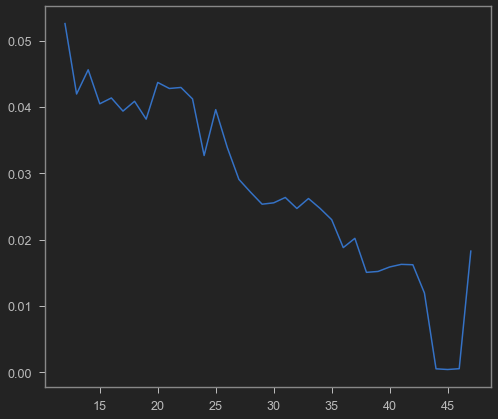

In [12]:
plt.plot(range(12, 48), r2)

In [13]:
n = 33

results = pd.DataFrame(results)

signal = (results).mean(axis=1)
#
signal = (signal-signal.shift(1).rolling(n).mean())/signal.shift(1).rolling(n).std() #변경 말것!
temp = pd.DataFrame({"returns":returns.shift(-1).mean(axis=1), "result":signal}).dropna()
test = temp.iloc[int(temp.shape[0]/4):2*int(temp.shape[0]/4), :]
test0 = temp.iloc[2*int(temp.shape[0]/4):, :]

mu = temp.result.iloc[:int(temp.shape[0]/4)].mean()
sd = temp.result.iloc[:int(temp.shape[0]/4)].std()

test.result = (test.result-mu)/sd

test0.result = (test0.result-mu)/sd


test["returns+"] = np.where(test["returns"] > 0, test["returns"], 0)
test0["returns+"] = np.where(test0["returns"] > 0, test0["returns"], 0)

test["port"] = test["returns"] * -1*test.result#np.where(-1*test.result >0,, 0)
test0["port"] = test0["returns"] * np.where( -1*test0.result > 0, 1, 0)

from sklearn.metrics import classification_report

print(f"{np.corrcoef(test.returns, -test.result)[1,0 ] ** 2 * 100:.4f}%")
    
print(classification_report(np.where(test.returns> 0, 1, 0), np.where(-test.result >0, 1, 0)))

2.6193%
              precision    recall  f1-score   support

           0       0.42      0.45      0.43        11
           1       0.60      0.56      0.58        16

    accuracy                           0.52        27
   macro avg       0.51      0.51      0.51        27
weighted avg       0.53      0.52      0.52        27



In [14]:
print(f"{np.corrcoef(test0.returns, -test0.result)[1,0 ] ** 2 * 100:.4f}%")
    
print(classification_report(np.where(test0.returns> 0, 1, 0), np.where(-test0.result >0, 1, 0)))

0.2726%
              precision    recall  f1-score   support

           0       0.42      0.40      0.41        20
           1       0.68      0.70      0.69        37

    accuracy                           0.60        57
   macro avg       0.55      0.55      0.55        57
weighted avg       0.59      0.60      0.59        57



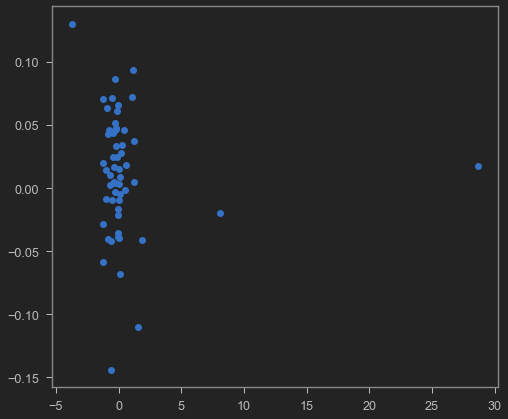

In [15]:
plt.plot(test0.result,test0.returns, "o")

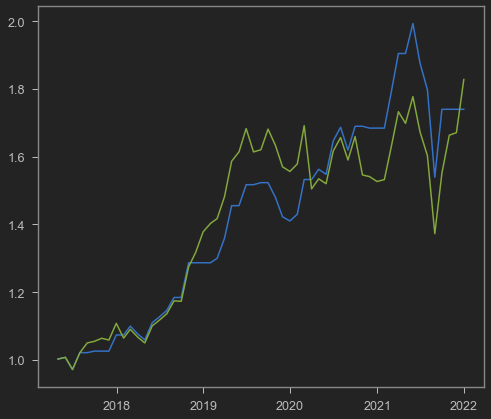

In [16]:
plt.plot((1+test0["port"]*1).cumprod())
plt.plot((1+test0.returns*1).cumprod())

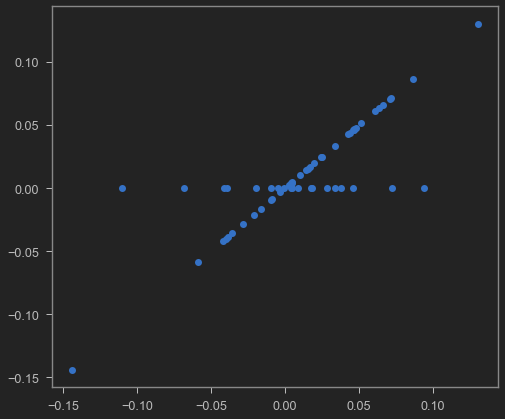

In [17]:
plt.plot(test0.returns ,test0["port"], "o")

In [18]:
print(test0["port"].mean() * np.sqrt(12)/ test0["port"].std())
print(test0["returns"].mean() * np.sqrt(12)/ test0["returns"].std())

0.9085207064489926
0.8475175892800865


In [19]:
test0.corr()

,returns,result,returns+,port
returns,1.000000,-0.052211,0.849395,0.829052
result,-0.052211,1.000000,-0.110253,-0.099552
returns+,0.849395,-0.110253,1.000000,0.743634
port,0.829052,-0.099552,0.743634,1.000000


In [20]:
sm.OLS(test0["port"], sm.add_constant(test0[["returns", "returns+"]])).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   port   R-squared:                       0.693
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                     60.92
Date:                Mon, 30 May 2022   Prob (F-statistic):           1.43e-14
Time:                        17:59:31   Log-Likelihood:                 136.35
No. Observations:                  57   AIC:                            -266.7
Df Residuals:                      54   BIC:                            -260.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0011      0.005     -0.238      0.813      -0.011       0.008
returns        0.5924      0.119      4.960      0.000       0.353       0.832
returns+       0.1898      0.192      0.991      0.326      -0.194       0.574
==============================================================================
Omnibus:                       11.862   Durbin-Watson:                   1.688
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               19.032
Skew:                          -0.639   Prob(JB):                     7.37e-05
Kurtosis:                       5.526   Cond. No.                         72.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

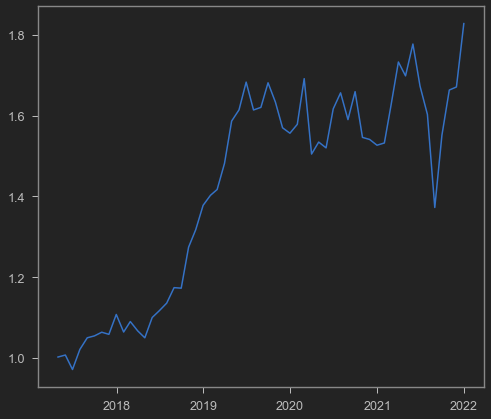

In [21]:
plt.plot((1+test0["returns"]).cumprod())

In [22]:
np.mean(np.where(test0["returns"]>0, 1, 0))

0.6491228070175439

In [23]:
from itertools import combinations as c

def estimation(bench, port):
    n0 = 0
    n = 0
    for t1, t2, t3 in c(range(len(bench)), 3):
        n0 += 1 
        rms = bench.iloc[[t1, t2, t3]].sort_values() 
        trueT1, trueT2, trueT3 = rms.index 
        betaH = (port.loc[trueT3] - port.loc[trueT2]) / (bench.loc[trueT3] - bench.loc[trueT2]) 
        betaL = (port.loc[trueT2] - port.loc[trueT1]) / (bench.loc[trueT2] - bench.loc[trueT1])
        
        if betaH > betaL:       
            n += 1          
    return 2*(n / n0) -1
          
def kernel(rms, ris):
    
    rm1, rm2, rm3 = rms
    ri1, ri2, ri3 = ris   
    premise = rm1 < rm2 and rm2 < rm3
    
    if not premise:       
        return 0
    
    betaH = (ri3 - ri2) / (rm3 - rm2)        
    betaL = (ri2 - ri1) / (rm2 - rm1)
    conclusion = betaH > betaL
       
    if  premise and not conclusion:       
        return 0   
    else:
      
        return 1

def stanardE(bench, port, esti):
    sum0 = 0
    for t1 in bench.index:   
        sum1 = 0     
        n0 = 0    
        for t2, t3 in c(bench.index, 2):            
            n0 += 1           
            sum1 += kernel(bench.loc[[t1, t2, t3]], port.loc[[t1, t2, t3]])
        sum1 = (sum1 / n0 - esti) ** 2       
        sum0 += sum1
    var = 9 / len(bench.index) * sum0
    return np.sqrt(var)
    
from scipy.stats import norm

def nonParaMT(bench, port):
    
    esti = estimation(bench, port)
    se = stanardE(bench, port, esti)
    statistic = esti * np.sqrt(len(bench)) /se
    pVal = 1 - norm.cdf(statistic, loc=0, scale=1)
    return esti, se , statistic, pVal

In [24]:
nonParaMT(test0["returns"], test0["port"])

(-0.25037593984962403,
 0.9963193242547572,
 -1.8972801655271554,
 0.9711045143312425)